<a href="https://colab.research.google.com/github/wonyoung-ji/goyangfifteen/blob/master/Goyang_Public_bicycles_EDA_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 준비

## (1) 구글드라이브연동

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## (2) 필요한 패키지 불러오기

In [ ]:
!pip install geopandas
!pip install geojson
!pip install haversine     # 좌표간 거리 구하기
!pip install tqdm

     |████████████████████████████████| 972kB 2.8MB/s 
     |████████████████████████████████| 14.7MB 289kB/s 
     |████████████████████████████████| 10.9MB 47.0MB/s 


In [ ]:
import json
import pandas as pd
import numpy as np
import geojson
from haversine import haversine
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import missingno as mnso
from shapely.geometry import shape, GeometryCollection, Point
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'NanumGothic'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import matplotlib.font_manager as fm
from pandas.plotting import register_matplotlib_converters
import matplotlib as mpl

fontpath = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
plt.rcParams["figure.figsize"] = (20, 10)
register_matplotlib_converters()
# mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumGothic')
# fm._rebuild()

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
# matplotlib 폰트를 Nanum 폰트로 지정
plt.rc('font', family='NanumGothic') 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

# 본론

## (1) 스테이션 정보 손보기

### (1).1. 동 구하기

In [ ]:
df_2=pd.read_csv('/content/gdrive/My Drive/고양시피프틴/02.자전거스테이션.csv')
df_2

,Station_ID,STATION_NAME,거치대 수량,위도,경도
0,101,어울림마을 701동 앞,20,37.654775,126.834584
1,103,대림e-편한세상106동,20,37.660442,126.840377
2,104,탄현마을8단지,25,37.698523,126.766042
3,105,KT 덕양지사 앞,20,37.655244,126.839261
4,106,원당역 앞 공영주차장,30,37.653410,126.842530
...,...,...,...,...,...
159,350,★하이파크5단지 502동앞 버스정류장,20,37.697867,126.753089
160,351,◆일산에듀포레 푸르지오,40,37.702259,126.767231
161,352,◆꿈에그린203동앞,40,37.666425,126.749244
162,353,◆꿈에그린106동앞,40,37.666720,126.750784


In [ ]:
df_7=pd.read_csv('/content/gdrive/My Drive/고양시피프틴/07.인구통계.csv')

df_7['총인구수']=df_7['총인구수'].str.replace(',', '').astype('float64')
df_7=df_7[df_7['조회기준']=='2019년12월']    # 가장 최신 데이터 사용
df_7=df_7[df_7['총인구수']<=250000]          # 필요없는 데이터 제거
df_7.head()

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율
107,경기도 고양시 덕양구 주교동(4128151000),2019년12월,15748.0,"7,362",2.14,"8,126","7,622",1.07
143,경기도 고양시 덕양구 원신동(4128152000),2019년12월,23942.0,"9,419",2.54,"11,568","12,374",0.93
179,경기도 고양시 덕양구 흥도동(4128153000),2019년12월,44565.0,"18,311",2.43,"21,702","22,863",0.95
215,경기도 고양시 덕양구 성사1동(4128154000),2019년12월,22062.0,"9,676",2.28,"10,928","11,134",0.98
251,경기도 고양시 덕양구 성사2동(4128155000),2019년12월,11729.0,"4,783",2.45,"5,689","6,040",0.94


In [ ]:
geo_path_34="/content/gdrive/My Drive/고양시피프틴/34.행정경계(행정동기준).geojson"
geo_str_34=geojson.load(open(geo_path_34,encoding='utf-8'))
geo_str_34

{"crs": {"properties": {"name": "urn:ogc:def:crs:OGC:1.3:CRS84"}, "type": "name"}, "features": [{"geometry": {"coordinates": [[[[126.835138, 37.676835], [126.835169, 37.676584], [126.835196, 37.676321], [126.835223, 37.676218], [126.835248, 37.675969], [126.835269, 37.675854], [126.835242, 37.675556], [126.835243, 37.675498], [126.835218, 37.675428], [126.835221, 37.675395], [126.835106, 37.675151], [126.834979, 37.674919], [126.835111, 37.674796], [126.835278, 37.674627], [126.835316, 37.674591], [126.835332, 37.674575], [126.835355, 37.674593], [126.835711, 37.674254], [126.835773, 37.674103], [126.835804, 37.674091], [126.835856, 37.67407], [126.835949, 37.674027], [126.836158, 37.673745], [126.836396, 37.673432], [126.836466, 37.673158], [126.836511, 37.673103], [126.836535, 37.673082], [126.836613, 37.673009], [126.83669, 37.672946], [126.837199, 37.67271], [126.837262, 37.672692], [126.837351, 37.672513], [126.837614, 37.672338], [126.83798, 37.67225], [126.838167, 37.672093], [1

In [ ]:
point= [Point(xy) for xy in zip(df_2.경도, df_2.위도)]  # 모든 스테이션의 (경도, 위도)를 가지고 있음

dong=[]
id=[]

for feature in geo_str_34['features']:                      
    polygon = shape(feature['geometry'])               # geostr내의 행정동 좌표값을 각각 가져와서 polygon 형태로 만듦
    for p in range(len(point)):
      if polygon.contains(point[p]):                    # 행정동이 스테이션의 (경도, 위도)를 가지고 있다면
        dong.append(feature['properties']['행정동명'])  # 그 행정동의 이름을 dong에 넣고
        id.append(df_2['Station_ID'][p])                # 스테이션의 이름을 id에 넣음
        
st_d=pd.DataFrame([dong,id])      # 스테이션별 좌표와, 스테이션이 위치한 동의 이름으로 df만듦
st_d=st_d.T
st_d.columns=['dong','Station_ID']
st_d=st_d[['Station_ID','dong']]
st_d

,Station_ID,dong
0,146,주교동
1,170,원신동
2,171,원신동
3,172,원신동
4,173,원신동
...,...,...
159,346,송산동
160,347,송산동
161,348,송산동
162,349,송산동


### (1).2 구 구하기

In [ ]:
df_8=gpd.read_file('/content/gdrive/My Drive/고양시피프틴/08.행정경계(시군구).geojson')
df_8

,SIG_CD,SIG_KOR_NM,geometry
0,41281,고양시덕양구,"MULTIPOLYGON (((126.92910 37.74849, 126.92964 ..."
1,41285,고양시일산동구,"MULTIPOLYGON (((126.77762 37.67899, 126.77825 ..."
2,41287,고양시일산서구,"MULTIPOLYGON (((126.76703 37.70717, 126.76719 ..."


In [ ]:
geo_path_8='/content/gdrive/My Drive/고양시피프틴/08.행정경계(시군구).geojson'
geo_str_8= geojson.load(open(geo_path8,encoding='utf-8'))
geo_str_8

{"crs": {"properties": {"name": "urn:ogc:def:crs:OGC:1.3:CRS84"}, "type": "name"}, "features": [{"geometry": {"coordinates": [[[[126.929096, 37.748485], [126.929644, 37.748136], [126.930189, 37.747785], [126.930665, 37.747488], [126.93129, 37.747065], [126.931846, 37.746678], [126.932164, 37.746471], [126.93255, 37.746219], [126.933048, 37.745901], [126.933072, 37.745886], [126.93046, 37.744209], [126.930362, 37.744145], [126.930457, 37.740037], [126.93114, 37.73765], [126.930437, 37.736794], [126.930619, 37.736271], [126.930627, 37.736117], [126.930631, 37.736037], [126.929996, 37.736046], [126.929886, 37.736057], [126.929383, 37.736108], [126.928569, 37.736162], [126.928566, 37.736162], [126.928485, 37.736104], [126.927138, 37.735143], [126.927047, 37.735161], [126.926597, 37.735214], [126.926593, 37.735215], [126.926587, 37.735081], [126.926538, 37.734079], [126.925529, 37.733079], [126.925155, 37.73306], [126.923317, 37.732861], [126.922841, 37.732437], [126.922762, 37.732347], [12

In [ ]:
# 스테이션의 좌표로 '구' 찾기

point= [Point(xy) for xy in zip(df_2.경도, df_2.위도)]  # 모든 스테이션의 (경도, 위도)를 가지고 있음

gu=[]
location=[]
id=[]

for feature in geo_str_8['features']:                      
    polygon = shape(feature['geometry'])               # geostr내의 행정동 좌표값을 각각 가져와서 polygon 형태로 만듦
    for p in range(len(point)):
      if polygon.contains(point[p]):                    # 행정동이 스테이션의 (경도, 위도)를 가지고 있다면
        gu.append(feature['properties']['SIG_KOR_NM'])  # 그 행정구의 이름을 gu에 넣고
        location.append(point[p])                       # 스테이션의 (경도, 위도)를 location에 넣고
        id.append(df_2['Station_ID'][p])                # 스테이션의 이름을 id에 넣음
        
st_g=pd.DataFrame([gu,location,id])      # 스테이션별 좌표와, 스테이션이 위치한 동의 이름으로 df만듦
st_g=st_g.T
st_g.columns=['gu','좌표','Station_ID']
st_g[['Station_ID','좌표','gu']]
st_g=st_g[['Station_ID','gu']]
st_g



,Station_ID,gu
0,101,고양시덕양구
1,103,고양시덕양구
2,105,고양시덕양구
3,106,고양시덕양구
4,110,고양시덕양구
...,...,...
159,349,고양시일산서구
160,350,고양시일산서구
161,351,고양시일산서구
162,352,고양시일산서구


### (1).3 완벽한 데이터정보

In [ ]:
station=pd.merge(df_2,st_d,on='Station_ID')
station=pd.merge(station,st_g,on='Station_ID')
station=station[['gu','dong','Station_ID','STATION_NAME','거치대 수량','경도','위도']]
station

,gu,dong,Station_ID,STATION_NAME,거치대 수량,경도,위도
0,고양시덕양구,성사2동,101,어울림마을 701동 앞,20,126.834584,37.654775
1,고양시덕양구,성사1동,103,대림e-편한세상106동,20,126.840377,37.660442
2,고양시일산서구,탄현동,104,탄현마을8단지,25,126.766042,37.698523
3,고양시덕양구,성사1동,105,KT 덕양지사 앞,20,126.839261,37.655244
4,고양시덕양구,성사1동,106,원당역 앞 공영주차장,30,126.842530,37.653410
...,...,...,...,...,...,...,...
159,고양시일산서구,송산동,350,★하이파크5단지 502동앞 버스정류장,20,126.753089,37.697867
160,고양시일산서구,탄현동,351,◆일산에듀포레 푸르지오,40,126.767231,37.702259
161,고양시일산서구,대화동,352,◆꿈에그린203동앞,40,126.749244,37.666425
162,고양시일산서구,대화동,353,◆꿈에그린106동앞,40,126.750784,37.666720


## (2) 스테이션 찍어보기

### (2).1 스테이션

In [ ]:
map_station = folium.Map(location=[station['위도'].mean(), station['경도'].mean()], zoom_start=10.8, tiles='CartoDB positron')
folium.GeoJson(geo_str_34).add_to(map_station)

for i, row in station.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=1,
        color='red',
        fill=True,
    ).add_to(map_station)
map_station

밀집이 편중되어 있음 --> 구역마다 단절되어 보임.


### (2).2 히트맵으로 찍어보기

In [ ]:
map_station_heat = folium.Map(location=[station['위도'].mean(), station['경도'].mean()], zoom_start=10.8, tiles='CartoDB positron')
plugins.HeatMap(station[['위도', '경도']].values.tolist(),
                        radius=10, blur=5
                        ).add_to(map_station_heat)
plugins.Fullscreen(position='topright').add_to(map_station_heat)
map_station_heat

일산동구, 서구에 밀집도가 높다.

## (3) 대여소 개수

### (3).1 동별

In [ ]:
map_dong_count = folium.Map(location=[station['위도'].mean(), station['경도'].mean()], zoom_start=11,tiles='cartodbpositron')

folium.Choropleth(geo_data=geo_str_34,
                  data=station,
                  columns=['dong','거치대 수량'],
                  key_on='feature.properties.행정동명', 
                  fill_color='Blues').add_to(map_dong_count)
map_dong_count

두 구역을 중심으로 밀집되어 있음

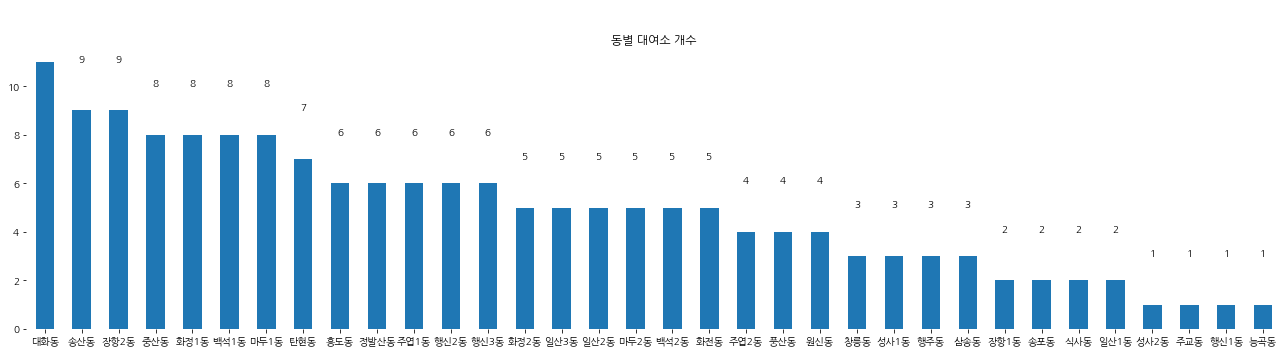

In [ ]:
dong_have_bikes =station.groupby('dong').size()
dong_have_bikes.sort_values(ascending=False, inplace=True)

ax = dong_have_bikes.plot(kind='bar', figsize=(18, 5), rot=0, title="동별 대여소 개수")
for p in ax.patches: 
     left, bottom, width, height = p.get_bbox().bounds 
     ax.annotate("%d"%(height), (left+width/2, height+2), ha='center')
plt.box(False)
plt.xlabel('')
plt.tight_layout()
plt.show()

대화동이 11개로, 스테이션 수가 가장 많다.
성사2동, 주교동, 행신1동, 능곡동이 1개로 가장 적다.

### (3).2 구별

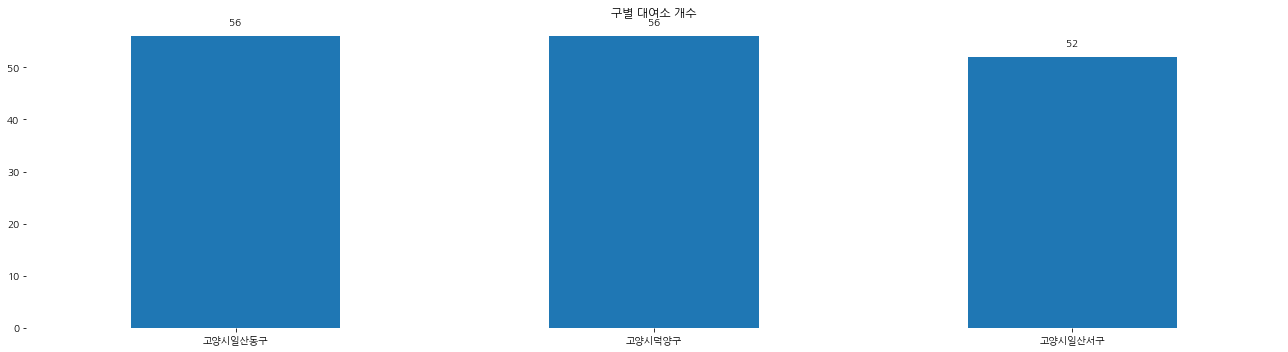

In [ ]:
gu_have_bikes =station.groupby('gu').size()
gu_have_bikes.sort_values(ascending=False, inplace=True)

ax = gu_have_bikes.plot(kind='bar', figsize=(18, 5), rot=0, title="구별 대여소 개수")
for p in ax.patches: 
     left, bottom, width, height = p.get_bbox().bounds 
     ax.annotate("%d"%(height), (left+width/2, height+2), ha='center')
plt.box(False)
plt.xlabel('')
plt.tight_layout()
plt.show()

대여소 개수가 구별로 큰 차이가 나지는 않음.


In [ ]:
gu_map_count = folium.Map(location=[station['위도'].mean(), station['경도'].mean()], zoom_start=11, tiles='cartodbpositron')
folium.Choropleth(geo_data=geo_str_8,
                  data=gu_have_bikes,
                  key_on='feature.properties.SIG_KOR_NM',
                  fill_color='Blues').add_to(gu_map_count)
gu_map_count

## (4) 대여소 당 평균 거치대 수

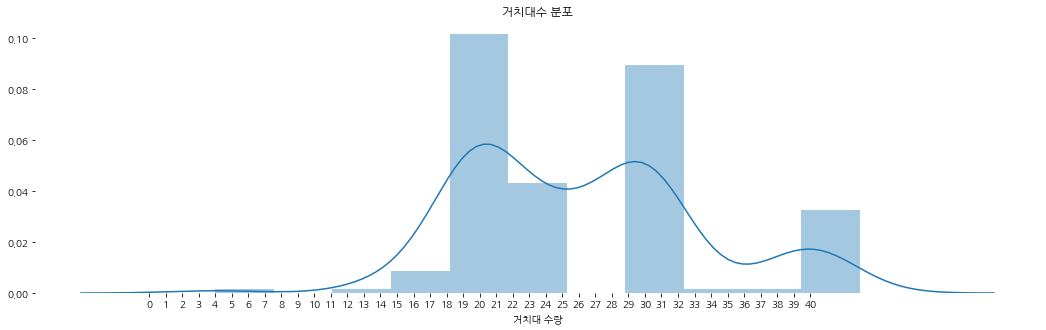

In [ ]:
plt.figure(figsize=(18, 5))
sns.distplot(station['거치대 수량'])
plt.title("거치대수 분포")
plt.xticks(range(0, 41))
plt.box(False)
plt.show()

대형스테이션 수가 일부 존재 --> 사용인구가 많아서 or 주변 스테이션이 없어서\
평균적으로 20개, 30개로 분포되어 있음

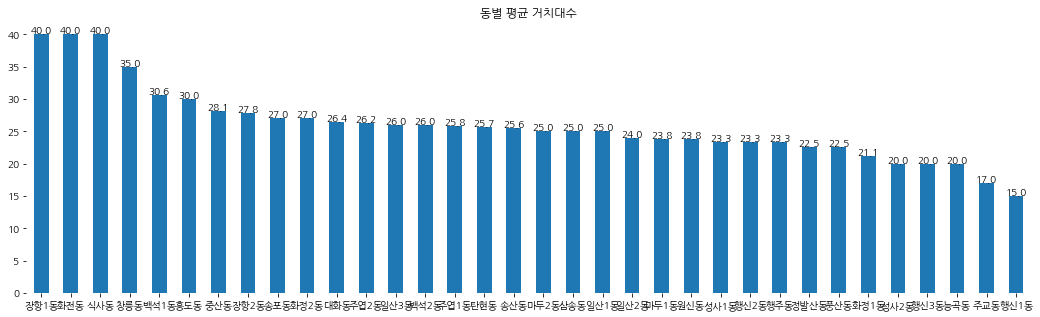

In [ ]:
bike_rental = station.groupby('dong')['거치대 수량'].sum()
bike_rental = bike_rental / dong_have_bikes
bike_rental.sort_values(ascending=False, inplace=True)

ax = bike_rental.plot(kind='bar', figsize=(18, 5), rot=0, title="동별 평균 거치대수")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%.1f"%(height), (left+width/2, height+0.3), ha='center')
plt.box(False)
plt.xlabel("")
plt.show()

top 3\
장항1동: 호수공원의 영향으로 많이 배치 2개 존재 \
화전동: 산 아래에 위치한 동. 5개 존재 \ 
식사동: 스테이션이 딱 2개 존재.


tail 3\
행신1동: 동 면적이 작음. 스테이션 1개 존재\
주교동: 밀집 두 구역 사이에 위치한 동. 스테이션 1개 존재\
능곡동: 밀집 두 구역 사이에 위치한 동. 스테이션 1개 존재


In [ ]:
bike_map = folium.Map(location=[station['위도'].mean(), station['경도'].mean()], zoom_start=10.8, tiles='cartodbpositron')
folium.Choropleth(geo_data=geo_str_34,
                  data=bike_rental,
                  key_on='feature.properties.행정동명', 
                  fill_color='Blues').add_to(bike_map)
bike_map

## (5) 가장 가까운 대여소간 평균거리

### (5).1. 구별 대여소간 평균거리

In [ ]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    m = 1000 * km
    return m

In [ ]:
station.groupby('dong')

In [ ]:

dict_dists = {}
for name, df in station.groupby('gu'):
    dists = []
    for i, i_row in df.iterrows():
        min_dist = float('INF')
        
        for j, j_row in df.iterrows():
            if i == j:
                continue
            distance = haversine(i_row['경도'], i_row['위도'], j_row['경도'], j_row['위도'])       
            min_dist = distance if distance < min_dist else min_dist
        if min_dist == float('INF'):
          min_dist = 0
        dists.append(min_dist)
    dict_dists[name] = dists
#dict_dists

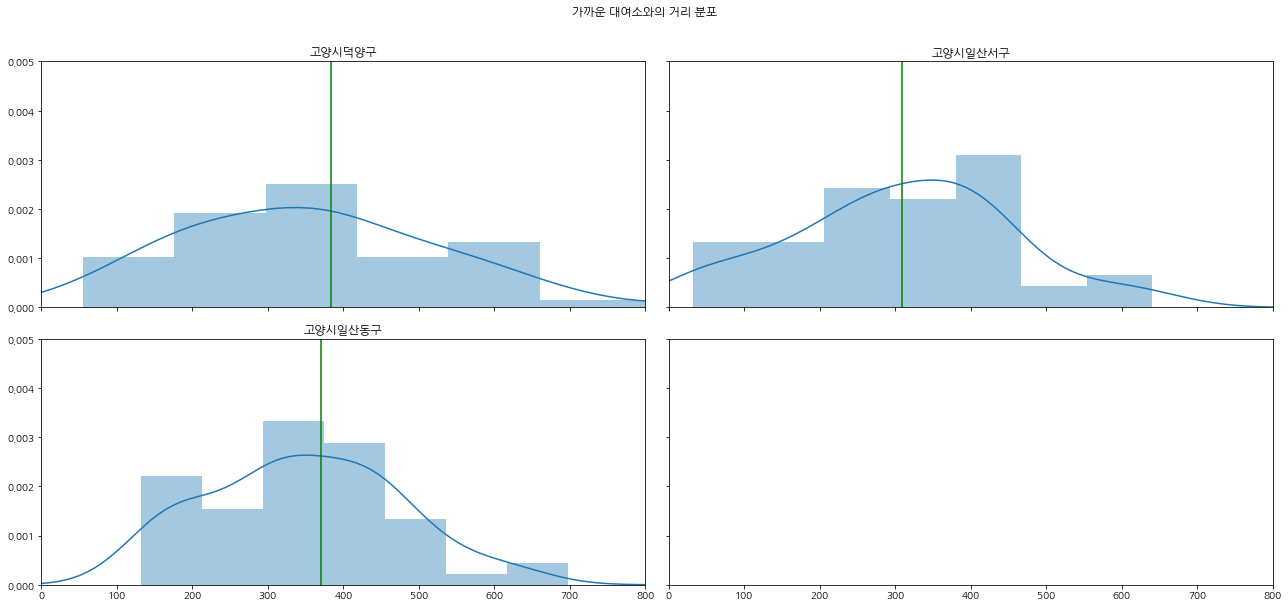

In [ ]:
fig, axes = plt.subplots(2,2, figsize=(18, 8), sharex=True, sharey=True)

i, j = 0, 0
for name, dists in dict_dists.items():
    sns.distplot(dists, ax=axes[j][i])
    axes[j][i].set_title(name)
    axes[j][i].axvline(np.array(dists).mean(), color='green')
    j += 1
    if j >= 2:
        i += 1
        j = 0

fig.suptitle("가까운 대여소와의 거리 분포", y=1.05)
plt.xlim(0, 800)
plt.ylim(0,0.005)
fig.tight_layout()
plt.show()

>덕양구: 지형이 스테이션 분포에 영향을 줌. 스테이션간의 거리가 멀어져서 평균값 높게 측정 \
일산서구: 밀집도가 높음. 거리간의 평균값이 낮음. 스테이션이 고르게 분포되어 있음. \
일산동구: 가까운 곳, 먼 곳(?) 둘 다 존재. 호수공원의 존재력이 커보임.

>세 구 모두 평균 스테이션간의 거리 300m~400m 사이


### (5).2. 동별 대여소간 평균거리

In [ ]:

dict_dists = {}
for name, df in station.groupby('dong'):
    dists = []
    for i, i_row in df.iterrows():
        min_dist = float('INF')
        
        for j, j_row in df.iterrows():
            if i == j:
                continue
            distance = haversine(i_row['경도'], i_row['위도'], j_row['경도'], j_row['위도'])       
            min_dist = distance if distance < min_dist else min_dist
        if min_dist == float('INF'):
          min_dist = 0
        dists.append(min_dist)
    dict_dists[name] = dists
#dict_dists

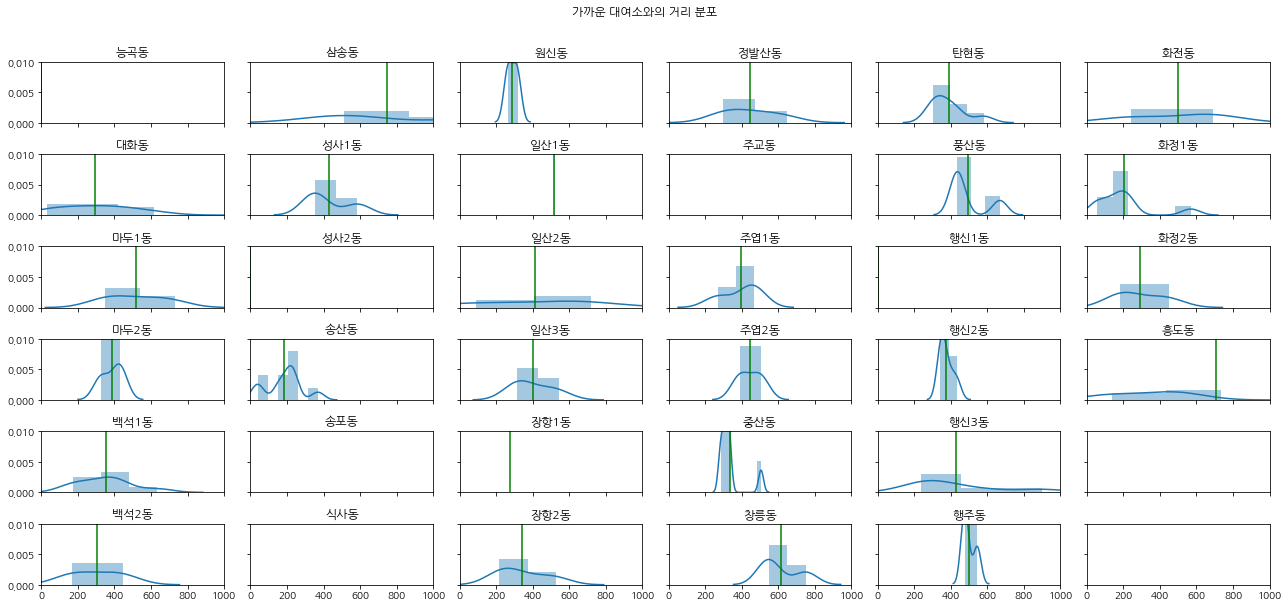

In [ ]:
fig, axes = plt.subplots(6,6, figsize=(18, 8), sharex=True, sharey=True)

i, j = 0, 0
for name, dists in dict_dists.items():
    sns.distplot(dists, ax=axes[j][i])
    axes[j][i].set_title(name)
    axes[j][i].axvline(np.array(dists).mean(), color='green')
    j += 1
    if j >= 6:
        i += 1
        j = 0

fig.suptitle("가까운 대여소와의 거리 분포", y=1.05)
plt.xlim(0, 1000)
plt.ylim(0,0.01)
fig.tight_layout()
plt.show()

### (5).3. 거리 별 그룹화 
-- 400m 이하 / 400m ~ 600m / 600m 이상

In [ ]:
# # fig, axes = plt.subplots(6,6, figsize=(18, 8), sharex=True, sharey=True)

# # i, j = 0, 0
# for name, dists in dict_dists.items():
#     # sns.distplot(dists, ax=axes[j][i])
#     # axes[j][i].set_title(name)
#     # axes[j][i].axvline(np.array(dists).mean(), color='green')
#     print(np.array(dists).mean())

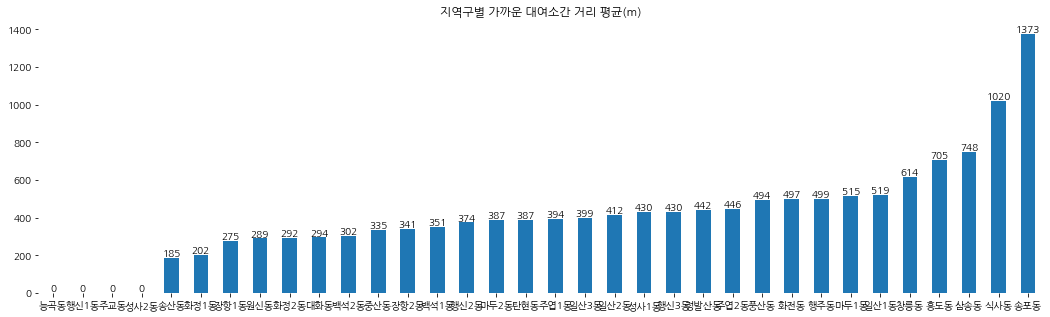

In [ ]:

dist_means = {name: np.mean(dists) for name, dists in dict_dists.items() }
dist_means = pd.Series(dist_means)
dist_means.sort_values(inplace=True)

ax = dist_means.plot(kind='bar', figsize=(18, 5), rot=0, legend=False, title="지역구별 가까운 대여소간 거리 평균(m)")
for p in ax.patches: 
    left, bottom, width, height = p.get_bbox().bounds 
    ax.annotate("%d"%(height), (left+width/2, height+10), ha='center')
plt.box(False)
plt.show()

능곡동, 행신1동, 주교동, 성사2동: 대여소 1개\
송포동: 대여소 2개 -- 동 모양이 이상함...


In [ ]:
# 거리가 멀수록 진한 색
bike_map = folium.Map(location=[station['위도'].mean(), station['경도'].mean()], zoom_start=10.8, tiles='cartodbpositron')
folium.Choropleth(geo_data=geo_str_34,
                  data=dist_means,
                  key_on='feature.properties.행정동명', 
                  fill_color='Blues').add_to(bike_map)
bike_map